# Analysis notebook
This notebook contains the analysis pipeline and figures for the manuscript: Voorhies et al. (2020). *Cognitive insights from evoluationarily new brain structures in prefrontal cortex* (under review)

For simplicity, this notebook references cleaned/formatted data from .csv files included in this repository. 
If you have any questions about data cleaning process, storage, or would like access to raw data please contact Willa Voorhies (wvoorhies@berkeley.edu).

## software requirements ## 
* software: Please consult the README.txt file for specific package and version requirements.

## data ###
* All data necessary for the analyses and figures is included in this repository.
* Morphological data was extracted with freesurfer (see manuscript methods). A sample function to extract the sulcal metrics of interest from cortical surface reconstructions is included here. Testing this requires access to a freesurfer directory. Please contact Willa Voorhies if you have additional questions about the sulcal data.  


## Setup ##

In [78]:
#### load packages ####
import numpy as np
import pandas as pd
import nilearn
import nibabel as nib

### Set up rpy2 for R functionality

In [2]:
#### setup rpy2 ####
# run once at start of session
%load_ext rpy2.ipython

In [3]:
#### import robjects ####
import tzlocal
import rpy2.robjects 
from rpy2.robjects import r

In [4]:
#### import rpackages ####

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

rpy2.rinterface.NULL

In [18]:
### install R packages ###

# R package names
packnames = ('aov','tidyverse')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.

names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/Users/willav/Library/R/3.6/library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)


# Morphological data
For completeness, we include a sample function to extract morphological data (cortical thickness, sulcal depth) from cortical surface reconstructions. This step requires access to a freesurfer directory. It is **not** ncessary to run this step to test the rest of the pipeline. The output from this step has been formatted as a .csv file and is included in the repository. 

In [80]:
def morphological_metrics(subjects_dir, sub_list, labels, outdir):
    '''
                          Sulcal Depth and Morphology script 
    OUTPUT: a CSV saved to project folder with minimum/maximum sulcal depth for each sulcal label (normalized to deepest point in hemisphere)
    Also includes formatted morphological stats from freesurfer command 'mris_anatomicals' (eg. cortical thickness, GM-volumen, surface area, curvature).
    REQUIREMENTS: 
        1) Run the following freesurfer commands on all subjects:
            a) recon-all
            b) mris_anatomicals for all labels of interest
            output should be nested in freesurfer label directory in the following format:
            .../<subject>/<label>/label_stats/<hemi>.<label>.label.stats.txt
            eg. sub_1/label/label_stats/lh.MFS.label.stats.txt
            
        2) A subjects list in a .txt file. 
        
        3) Labels created for sulcus of interest in the format
            .../<subject>/<label>/<hemi>.<sulcus>.label.
            eg. .../sub_1/label/rh.MFS.label. 
        All labels should have output from mris_anatomicals.
        Split annotation files with annot2label command
        
        4) nibable and nilearn must be installed and operational
        
    INPUT:  
    - subjects dir = path to freesurfer subjects directory
    - sub_list = path to subjects list text file
    - labels = alabels of interest as an array of strings eg. ['MFS', 'CoS', 'OTS']
    - outdir = path to output directory
    
    RETURNS:
    - dataframe with cortical thickness and sulcal depth for every sulcus for each subject. 
'''

############# pull metrics from mris_anatomicals output ################################

    def anatomicals_output (sub, hemi, label):
        ''' 
        reads in output from mris_anatomicals and organizes into a df
        Parameters
        -----------
        label: str
        Returns
        -------
        outputs from mris_anatomicals as an array
        '''
        # Pull metrics from label txt file for each label for every subject and append to df. 

        # label stats directory
        label_dir = subjects_dir + '/{}/label/'.format(sub)
        labels_stats = subjects_dir + '/{}/label/label_stats/'.format(sub)

        # extract cortical thickness, volume, surface area and curvature for each label
        label_filename = label_dir + '{}.{}.label'.format(hemi,label)
        label_stats_filename = labels_stats + '{}.{}.label.stats.txt'.format(hemi,label)
        label_data = surface.load_surf_data(label_filename)

        # open label stats text file and pull cortical thickness from the bottom line of the file. 
        with open(label_stats_filename) as f: 
            lastN = list(f)[-1:]
            label_stats = np.array(lastN[0].split()[3], dtype=float)

        return label_stats

################################## compute mean/max sulcal depth from surface file #####################################################
    def calc_depth(sub, hemi, label):
        ''''
        computes total mean, max sulcal depth and also mean/max depth as percentage of maximum depth in hemi
        Parameters
        ----------
        label: str
        Returns
        --------
        depth values as an array
        '''
        if sub == 'fsaverage':
            sulc_path = subjects_dir + '/fsaverage/surf/{}.smoothsulc'.format(hemi)
        else:
            sulc_path = subjects_dir + '/{}/surf/{}.sulc'.format(sub, hemi)
            sulc_data = surface.load_surf_data(sulc_path)

        # Load .sulc file for label vertices
        label_filename = label_dir + '{}.{}.label'.format(hemi,label)
        label_data = surface.load_surf_data(sulc_path)

        # calculate sulcal depth by mean label value in .sulc file
        label_mean_depth = np.mean(sulc_data[label_data])
        label_max_depth = np.amax(sulc_data[label_data])

        # calculate mean sulcal depth as a percentage of max depth in subject
        sulc_data_pct_max = sulcaldata/np.amax(sulc_data)
        label_mean_depth_pct_max = np.mean(sulc_data_pct_max[label_data])

        return np.array([label_mean_depth, label_max_depth, label_mean_depth_pct_max])


######################## Compute and organize sulcal morphology data into a CSV ###################################### 
     # set up CSV

    columns =  ['sub', 'hemi', 'label',  'cortical_thickness_mean', 
                                        'sulcal_depth_mean', 'sulcal_depth_max',
                                        'norm_mean_sulcal_depth']
    df_anatomical = pd.DataFrame(columns = columns)

    # Compute morphological metrics for each subject

    for sub_hemi in sub_hemi_combos:
        sub = sub_hemi[0]
        hemi = sub_hemi[-1]

        for label in labels:
            # extract cortical thickness, volume, surface area and curvature for each label
            anatomicals = anatomicals_output(sub, hemi, label)

            # compute sulcal depth
            depth = calc_depth(sub, hemi, label)

            # append metrics to dataframe
            label_stats = np.append(anatomicals, depth)
            descriptives = [sub, hemi, label]
            df_row = pd.DataFrame([descriptvies + list(label_stats)], columns = columns)
            df_anatomical = pd.concat([df_anatomical, df_row], axis=0)

    # return a dataframe with all morphological metrics
    return df_anatomical

# Morphological Analyses #
Does sulcal morphology (depth, thickness) differ by hemisphere and/or sulcal type?

### Discovery sample

In [81]:
%%R
### load the data ###
Discovery_morphology = read.csv('Discovery_morphology.csv')

#### Depth ####
 A 2-way (hemi x type) RM-ANOVA to test for differences in sulcal depth

In [82]:
%%R
Discovery_depth.aov <- aov( norm_mean_sulcal_depth ~ hemi * type +
                           Error(sub/(hemi*type)), Discovery_morphology)

In [84]:
%%R
summary(Discovery_depth.aov)


Error: sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 27 0.4543 0.01682               

Error: sub:hemi
          Df  Sum Sq  Mean Sq F value Pr(>F)
hemi       1 0.00013 0.000131   0.018  0.895
Residuals 27 0.19845 0.007350               

Error: sub:type
          Df Sum Sq Mean Sq F value   Pr(>F)    
type       1  4.620   4.620   95.63 2.29e-10 ***
Residuals 27  1.304   0.048                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: sub:hemi:type
          Df Sum Sq Mean Sq F value Pr(>F)  
hemi:type  1 0.1228 0.12278   5.672 0.0246 *
Residuals 27 0.5845 0.02165                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 560  6.013 0.01074               


We see a main effect of type and an interaction between hemisphere and sulcal type

compute mean and standard dev for tertiary vs. primary/secondary

In [87]:
%%R
type_stats <- Discovery_morphology %>%
        # group tertiary vs. primary/secondary
        group_by(type) %>%

        # get mean and std. for each sulcal type
        summarize(Mean = mean(norm_mean_sulcal_depth),
                  sd = sd(norm_mean_sulcal_depth))
type_stats

# A tibble: 2 x 3
  type           Mean     sd
  <fct>         <dbl>  <dbl>
1 Non-Tertiary 0.218  0.0713
2 Tertiary     0.0425 0.169 


Tertiary sulci are more shallow than primary sulci

To probe the interaction we examine mean and stdev of tertiary vs. primary/secondary sulci separately in each hemisphere:

In [89]:
%%R
type_hemi_stats <- Discovery_morphology %>%
        # separate by type and hemisphere
        group_by(type, hemi) %>%

        # get mean and std.
        summarize(Mean = mean(norm_mean_sulcal_depth),
                  sd = sd(norm_mean_sulcal_depth))
type_hemi_stats

# A tibble: 4 x 4
# Groups:   type [2]
  type         hemi    Mean     sd
  <fct>        <fct>  <dbl>  <dbl>
1 Non-Tertiary lh    0.228  0.0693
2 Non-Tertiary rh    0.209  0.0723
3 Tertiary     lh    0.0230 0.169 
4 Tertiary     rh    0.0621 0.168 


Right hemisphere tertiary sulci are deeper than left hemisphere tertiary sulci. 

#### Thickness
 A 2-way (hemi x type) RM-ANOVA to test for differences in cortical thickness

In [90]:
%%R
## Compute the 2-way repeated measures ANOVA ##
Discovery_thick.aov <- aov( mean_cortical_thickness ~ hemi * type +
                           Error(sub/(hemi*type)), Discovery_morphology)

In [91]:
%%R
summary(Discovery_thick.aov)


Error: sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 27  9.117  0.3376               

Error: sub:hemi
          Df Sum Sq Mean Sq F value   Pr(>F)    
hemi       1  5.339   5.339   128.1 9.39e-12 ***
Residuals 27  1.126   0.042                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: sub:type
          Df Sum Sq Mean Sq F value Pr(>F)
type       1 0.1994 0.19936   2.625  0.117
Residuals 27 2.0503 0.07594               

Error: sub:hemi:type
          Df Sum Sq Mean Sq F value Pr(>F)
hemi:type  1 0.1307  0.1307   1.648   0.21
Residuals 27 2.1411  0.0793               

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 560  38.62 0.06897               


We see a main effect of hemisphere but no differences between tertiary and primary/secondary sulci

We can compare the mean and std between left and right hemisphere sulci:

In [92]:
%%R
type_stats <- Discovery_morphology %>%
        # LH vs. RH
        group_by(hemi) %>%

        # get mean and std.
        summarize(Mean = mean(mean_cortical_thickness),
                  sd = sd(mean_cortical_thickness))
type_stats

# A tibble: 2 x 3
  hemi   Mean    sd
  <fct> <dbl> <dbl>
1 lh     2.48 0.275
2 rh     2.30 0.289


The right hemisphere is thinner than the left hemisphere

### Replication sample

In [93]:
%%R
### load the data ###
Replication_morphology = read.csv('Replication_morphology.csv')

#### Depth
 A 2-way (hemi x type) RM-ANOVA to test for differences in sulcal depth

In [94]:
%%R
## Compute the 2-way repeated measures ANOVA ##
Replication_depth.aov <- aov( norm_mean_sulcal_depth ~ hemi * type +
                             Error(sub/(hemi*type)), Replication_morphology)

In [95]:
%%R
summary(Replication_depth.aov)


Error: sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 26 0.3848  0.0148               

Error: sub:hemi
          Df  Sum Sq Mean Sq F value Pr(>F)  
hemi       1 0.04319 0.04319   7.108  0.013 *
Residuals 26 0.15799 0.00608                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: sub:type
          Df Sum Sq Mean Sq F value   Pr(>F)    
type       1  6.454   6.454   136.5 7.57e-12 ***
Residuals 26  1.229   0.047                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: sub:hemi:type
          Df Sum Sq  Mean Sq F value Pr(>F)
hemi:type  1 0.0035 0.003516    0.26  0.615
Residuals 26 0.3522 0.013546               

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 540  5.493 0.01017               


As in the Discovery sample, we see a main effect of sulcal type, but no interaction

We then compute the mean and stdev of tertiary vs. non-tertiary sulci

In [22]:
%%R
type_stats <- Replication_morphology %>%
        # tertiary vs. primary/secondary
        group_by(type) %>%

        # get mean and std.
        summarize(Mean = mean(norm_mean_sulcal_depth),
                  sd = sd(norm_mean_sulcal_depth))
type_stats

# A tibble: 2 x 3
  type           Mean     sd
  <fct>         <dbl>  <dbl>
1 Non-Tertiary 0.228  0.0673
2 Tertiary     0.0161 0.163 


As in the Discovery sample, tertiary sulci are more shallow than primary/secondary sulci

#### Thickness
 A 2-way (hemi x type) RM-ANOVA to test for differences in cortical thickness

In [96]:
%%R
## Compute the 2-way repeated measures ANOVA ##
Replication_thick.aov <- aov( mean_cortical_thickness ~ hemi * type +
                             Error(sub/(hemi*type)), Replication_morphology)

In [99]:
%%R
summary(Replication_thick.aov)


Error: sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 26  11.83  0.4551               

Error: sub:hemi
          Df Sum Sq Mean Sq F value   Pr(>F)    
hemi       1  4.450   4.450   42.91 6.05e-07 ***
Residuals 26  2.697   0.104                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: sub:type
          Df Sum Sq Mean Sq F value Pr(>F)
type       1 0.1839 0.18390   2.312   0.14
Residuals 26 2.0676 0.07952               

Error: sub:hemi:type
          Df Sum Sq Mean Sq F value Pr(>F)
hemi:type  1  0.086 0.08598   1.892  0.181
Residuals 26  1.182 0.04545               

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 540  51.93 0.09617               


Once again, we see a main effect of hemisphere.

We can look at the mean and stdev of thickness to compare the two hemispheres

In [101]:
%%R

type_stats <- Replication_morphology %>%
        # lh vs rh
        group_by(hemi) %>%

        # get mean and std.
        summarize(Mean = mean(mean_cortical_thickness),
                  sd = sd(mean_cortical_thickness))
type_stats

# A tibble: 2 x 3
  hemi   Mean    sd
  <fct> <dbl> <dbl>
1 lh     2.37 0.291
2 rh     2.20 0.363


Consistent with the Discovery sample, the RH is thinner than LH

### Plot morphological analyses
visualize the above analyses

In [102]:
%%R
library('tidyverse')

#### Set boxplot

In [103]:
%%R 
#### set boxplot theme ####

set_theme <- function(){
    
    # Customize axis and legend
    set_theme = theme(
            # set axis title size
            axis.title.x = element_blank(), 
            axis.title.y = element_text(color="#333333", angle=90,size=12),
        
            # set axis text size
            axis.text = element_text( color='#333333', size = 14 ),
        
            # rotate x-axis 45 degrees
            axis.text.x = element_text(angle =45, hjust = 1, vjust = 1),
        
            #change background pannel
            panel.grid.major  = element_blank(), 
                                panel.grid.minor=element_blank(),
            # change lengend size
            legend.title = element_text(color="#333333",size = 12),
            legend.text = element_text( color = '#333333',size = 12),
            
            # set aspect ratio
            aspect.ratio = 1/1
    )
    # replace classic theme setting with our setting
    theme = theme_classic()%+replace% set_theme
    
    return(theme) 
    }

In [104]:
%%R
### customize scale ###
set_scale <- function (){
    scale = scale_fill_manual(name="Type", 
                      
            # manually set color scale
            values=c( "#a6bddb","#0072B2",
                    "#fdae6b","#D55E00"),
                      
            # manually set legend labels
            labels=c("LH primary/secondary", 
                "RH primary/secondary",
                "LH tertiary", 
                "RH tertiary"))
    return (scale)
}
    

In [105]:
%%R
#### set boxplot ####

boxplot <- function (ggplot_object, xlab, ylab, ymin, ymax){

   plot=ggplot_object + 
    
    # boxplot
    geom_boxplot() +

    # set y-axis limits
    ylim(ymin, ymax) +

    # set axis labels
    xlab(xlab) + 
    ylab(ylab)
        
    return(plot)
}

###  Depth 
figure 2c: Plot sulcal depth by sulcal type and hemisphere

#### Discovery

In [30]:
%%R

## set up Discovery data for plotting ##

# add a factor that combines sulcal type and hemisphere for color scale
Discovery_morphology$grp <- factor(paste(as.character(Discovery_morphology$type),
                                         Discovery_morphology$hemi, sep="_"))

# Add numbers to sulcal label to allow easy comaprison with figures 2a & b
Discovery_morphology$pltlabel <- recode_factor(Discovery_morphology$label,
                                               central='1.central',
                                               sprs='2.sprs',
                                               iprs='3.iprs', 
                                               ifs='4.ifs ',
                                               sfs_p='5.sfs_p',
                                               sfs_a='6.sfs_a',
                                               imfs_h='7.imfs_h',
                                               imfs_v='8.imfs_v',
                                               pmfs_p='9.pmfs_p',
                                              pmfs_i='10.pmfs_i',
                                               pmfs_a='11.pmfs_a',
                                               pimfs='12.pimfs')

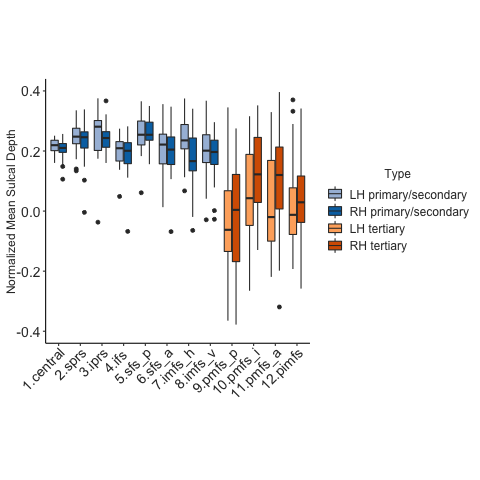

In [31]:
%%R 
#### Generate boxplot ####

# define data and aesthetics
ggplot_dis_depth <- ggplot(Discovery_morphology, aes(x = factor(pltlabel), y = norm_mean_sulcal_depth ,fill = grp))

boxplot(ggplot_dis_depth, "", "Normalized Mean Sulcal Depth", -0.4, 0.4) + 
set_theme() + set_scale()


#### Replication

In [34]:
%%R 
#### set up dataframe for plotting ####

# add a factor that combines sulcal type and hemisphere for color scale
Replication_morphology$grp <- factor(paste(as.character(Replication_morphology$type),
                                         Replication_morphology$hemi, sep="_"))

# Add numbers to sulcal label to allow easy comaprison with figures 2a & b
Replication_morphology$pltlabel <- recode_factor(Replication_morphology$label, 
                                               central='1.central',
                                               sprs='2.sprs',
                                               iprs='3.iprs', 
                                               ifs='4.ifs ',
                                               sfs_p='5.sfs_p',
                                               sfs_a='6.sfs_a',
                                               imfs_h='7.imfs_h',
                                               imfs_v='8.imfs_v',
                                               pmfs_p='9.pmfs_p',
                                               pmfs_i='10.pmfs_i',
                                               pmfs_a='11.pmfs_a',
                                               pimfs='12.pimfs')

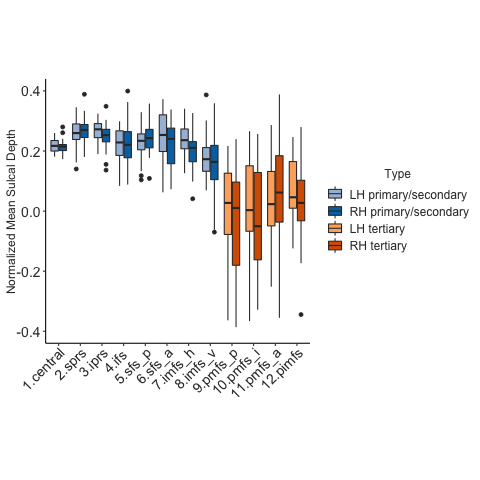

In [36]:
%%R 
#### Generate boxplot ####

# define data and aesthetics
ggplot_rep_depth <- ggplot(Replication_morphology, aes(x = factor(pltlabel), y = norm_mean_sulcal_depth ,fill = grp))

boxplot(ggplot_rep_depth, "", "Normalized Mean Sulcal Depth",-0.4, 0.4) + 
set_theme() +  set_scale()

### Thickness
Supplementary Figure 5: plot cortical thickness by sulcal type and hemisphere

#### Discovery

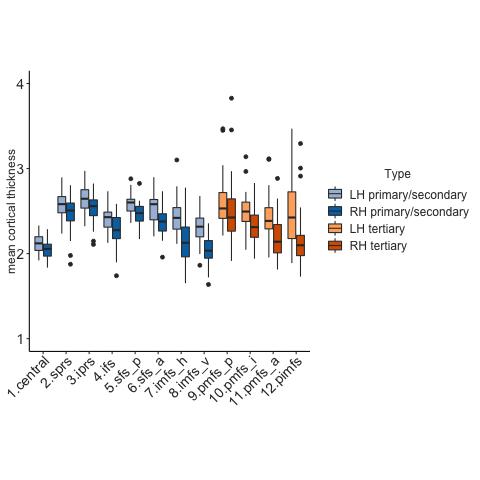

In [38]:
%%R 
#### Generate boxplot ####

# define data and aesthetics
ggplot_dis_thick <- ggplot(Discovery_morphology, aes(x = factor(pltlabel), y = mean_cortical_thickness ,fill = grp))

boxplot(ggplot_dis_thick, "", "mean cortical thickness", 1.0, 4.0) + 
set_theme() + set_scale()

#### Replication

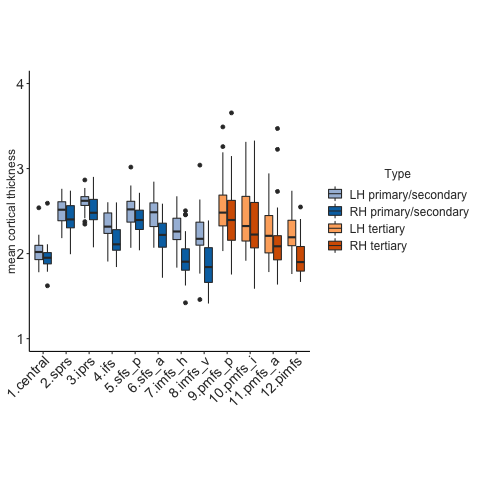

In [40]:
%%R 
#### Generate boxplot ####

# define data and aesthetics
ggplot_rep_thick <- ggplot(Replication_morphology, aes(x = factor(pltlabel), y = mean_cortical_thickness ,fill = grp))

boxplot(ggplot_rep_thick, "", "mean cortical thickness", 1.0, 4.0) + 
set_theme() + set_scale()

# Morphology - Behavior analyses
Does sulcal depth predict Matrix Reasoning score? 

In [41]:
## load data with behavior in wide format ## 

# Discovery
Discovery_depth = pd.read_csv('Discovery_Depth.csv')

In [42]:
# Replication
Replication_depth = pd.read_csv('Replication_Depth.csv')

## Discovery sample

### Model Selection
* **Behavioral metric** : Matrix reasoning score
* **Morphological metric** : normalized mean sulcal depth

We use a LASSO regression as a form of feature selection to determine which sulci, if any predict reasoning performance. We  use cross-validation to tune the shrinking paramater (alpha) and select the model that minimizes cross-validated mean seqared error. 

In [43]:
# import from sklearn CV and lasso
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.linear_model import Lasso

loo = LeaveOneOut()

Set up the lasso regression 

In [44]:
## Lasso ##
def lasso_(Xr, yr, alpha_vals, n_folds = loo):
    ''''
        Determine best paramters for LASSO regression and fit model
        input
        ----------
        Xr = predictors 
        yr = DV
        alpha_vals = array of possible alpha values to test 
        n_folds = folds for cross-validation. Default is loo
        Returns
        --------
        depth values as an array     
    '''

    # determine the alpha-value that minimizes MSE with GridSearchCV.
    lasso = Lasso()
    lasso_regressor = GridSearchCV(lasso, alpha_vals, scoring = 'neg_mean_squared_error', cv = n_folds)
    lasso_regressor.fit(Xr, yr)

    # best alpha and MSE
    best_alpha = lasso_regressor.best_params_
    best_MSE = lasso_regressor.best_score_

    # fit the best model
    best_model = lasso_regressor.best_estimator_
    best_model.fit(Xr,yr)
    best_model.predict(Xr)
    
    #best_model.score_
    return best_alpha, best_MSE, best_model.coef_


We will consider the LH and RH separately

In [45]:
## Separate Discovery data by hemisphere ## 

Discovery_RH_depth = Discovery_depth[Discovery_depth["hemi"] == 'rh']
Discovery_LH_depth = Discovery_depth[Discovery_depth["hemi"] == 'lh']


We make no assumptions about sulcal type. All sulci will be included as predictors in the model. We will fit the model with a very wide range of shrinking paramters (alpha). 

In [46]:
## set-up model ## 

#  predictors
Xr = ['central','sprs','iprs','ifs','sfs_a','sfs_p','ifs',
                         'imfs_v','imfs_h', 'pmfs_p','pmfs_a','pmfs_i','pimfs']
# DV
yr = ['MatrixR']

# alpha values
alpha = {'alpha':[1e3, 3e-3, 3e-2, 5e-2, 7e-2, 9e-2, 1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1, 3, 5, 10]}


First we teest whether sulcal depth of RH sulci is associated with reasoning performance

In [50]:
## Lasso on RH sulci ## 

rh_lasso = lasso_(Discovery_RH_depth[Xr], Discovery_RH_depth[yr], alpha)

We can see which alpha level provides the best fit

In [106]:
## best RH model ##
# alpha
print(rh_lasso[0])

# neg MSE 
print(rh_lasso[1])

{'alpha': 0.1}
-21.84346245136163


We can view the coefficients at this level of alpha to see which sulci remained as predictors in the model

In [107]:
# beta-vals
print(rh_lasso[2])

[ 0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -1.78404634  4.50306297
 11.88492217]


The best model predictions relies on only three RH tertiary sulci (pmfs_i, pmfs_a, pimfs)

We can then examine the relationship between LH sulci and reasoning

In [52]:
lh_lasso = lasso_(Discovery_LH_depth[Xr], Discovery_LH_depth[yr], alpha)

View which model gives us the best fit and the predictors

In [108]:
## best LH model ##
# alpha
print(lh_lasso[0])

# neg MSE 
print(lh_lasso[1])

# beta-vals
print(lh_lasso[2])

{'alpha': 1000.0}
-24.422496570644714


No LH sulci are associated with Matrix Reasoning score

### Plot Lasso
To dertermine the shrinking paramater for our model we fit a range of alpha values and selected the one that minimizes MSE-cv. We can visualize this model selection process by plotting the coefficients at every alpha level and the corresponding MSE (figure 3a) 


First we load in the MSE and CV from the lasso regression as an R dataframe

In [109]:
%%R
# load in coefficients and MSE from lasso as R dataframes for ggplot

lasso_coefs <- read.csv('plots/lasso_coefs.csv')
lasso_mse<- read.csv("plots/lasso_MSE.csv")

We then plot the absolute beta value for each predictor at each level of alpha

In [110]:
%%R
# make tile plot for lasso coefs
lasso_coef_plt <- ggplot(data = lasso_coefs, aes(x=as.factor(alpha_level), y=as.factor(Sulci))) +
                # tile plot
                geom_tile(aes(fill = abs(beta),), size=0.3) +
                
                # set coordinates
                coord_equal() +
                scale_y_discrete(limits = rev(levels(lasso_coefs$Sulci))) +

                # set color gradient
                scale_fill_gradient(low = "#E1E5EB", high = "#cb5100")+

                
                # set text object and axis labels
                geom_text(aes(label=round(beta, digits = 2), 
                              size = 1), size = 2)+
                
                # set axis and legend labels
                xlab("alpha level") +
                ylab('lateral PFC sulci') +
                labs(fill = "abs. beta") +
                
                # set theme
                theme(
                        # set axis title
                        axis.title.x = element_text(color="#333333",
                                                    size=12), 
                        axis.title.y = element_text(color="#333333", 
                                                    angle=90,size=14),
                        # set axis text
                        axis.text = element_text( color='#333333',
                                                 size = 12),
                        # set pannel
                        panel.grid.major  = element_blank(), 
                        panel.grid.minor=element_blank(),
                        
                        # set legend
                        legend.title = element_text(color="#333333",size = 12),
                        legend.text = element_text( color = '#333333',size = 12),
                        
                        # set aspect ratio
                        aspect.ratio = 1/1
                )

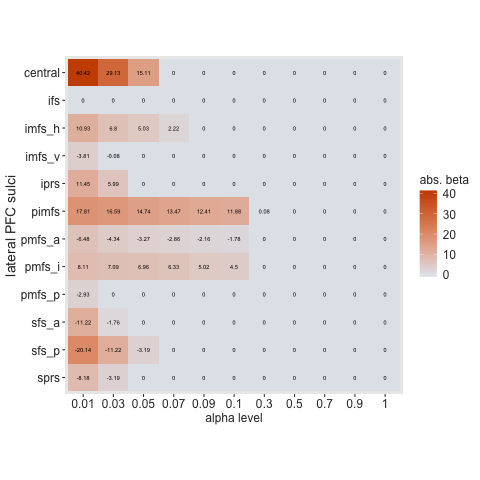

In [111]:
%%R
lasso_coef_plt

We can then visualize the corresponding MSE at each alpha level to assure ourselves that we have selected the alpha value that minimizes MSE

In [112]:
%%R
### make line plot of MSE ###

MSE <- (ggplot(lasso_mse, aes(x=log(alpha), y=MSE)) +
        # add smooth line
        geom_smooth( color = "#D25727" ,
                    span = 0.99, 
                    se = FALSE, 
                    size = 4) +

        # vertical line to indiciate lowest MSE at best alpha level
        geom_vline(xintercept = log(0.1), 
                   linetype="dotted", 
                   size = 3) +
        # axis labels
        xlab ('alpha-level')+
        ylab(' Cross Validated MSE') +
        
        # set theme
        theme_classic()+

        # customize theme
        theme(
            # set axis title
            axis.title.x = element_text(color="#333333",
                                          size=14), 
            axis.title.y = element_text(color="#333333",
                                        angle=90,size=14),
            # set axis text
            axis.text = element_text( color='#333333', 
                                     size = 14 ,hjust =0),
            # set lengend
            legend.text = element_text( color = '#333333',
                                       size = 12), 
            # set pannel
            panel.grid.minor=element_blank(),
            legend.title = element_text(color="#333333",
                                        size = 12),
            panel.border = element_rect(colour = "black", 
                                        fill=NA, size=1), 
            # set aspect ratio
            aspect.ratio = 10/20)
        )

/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `geom_smooth()` using method = 'loess' and formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


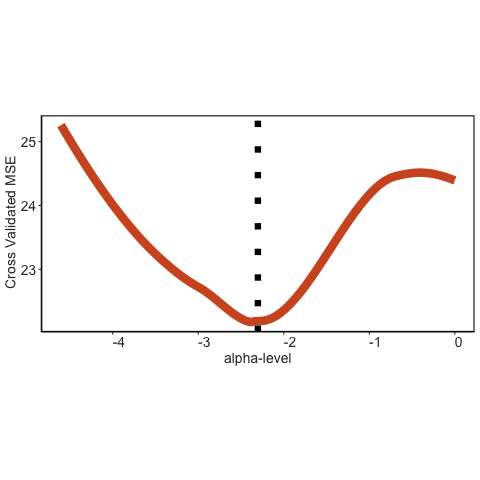

In [113]:
%%R
MSE

## Replication sample:

### Model Evaluation
After determining which sulci are relevant for reasoning performance we use these sulci to construct a model to predict reasoning in our independent replciation sample. To account for the wide age range and the correlation between age and reasoning (see supplementary) we include age as a predictor. we compare this model derived from the Discovery sample to alternative nested models. 

In [114]:
## load sklearn functions for loocv ##
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.utils import resample

#### Fit linear regression with loocv
We fit all of our models using a leave-out-out cross validation which is appropriate for small sample sizes

In [115]:
# LOOCV
def lm_loocv (Xr, yr, mod):
    """
    linear regression with a leave-one-subject out cross validation proceedure. 
    input: input: Xr = matrix or array of predictors from dataframe  in format X= df[['X1', 'X2', 'Xn']]
    yr = Array of DV of interest from dataframe in format y= df['yr']
    mod = model name as strip. will be used to save a .csv with model predictions are saved as file for later use
    returns: r_squared-cv, mean squared error, dataframe of measured and predicted y-values.

    """    
    
    # create arrays to append y-vals
    ytests = []
    ypreds = []
    
    # set input arrays as np objects
    X_array = np.array(Xr)
    y_array = np.array(yr)
 
     # split into train and test
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        # model to fit
        lm = linear_model.LinearRegression() 
        
        # fit model on training data
        model = lm.fit(X_train,y_train) 
        
        # generate predictions with testing data
        y_pred = lm.predict(X_test) 
        
        #there is only one y-test and y-pred per iteration over the loo.split, 
        #so we append each score to respective lists.
        
        ytests += list(y_test) #should be your original y input
        ypreds += list(y_pred)

    #get mean squared error and R2-cv values by comparing the test to the predicted.       
    rr = metrics.r2_score(ytests, ypreds)
    ms_error = metrics.mean_squared_error(ytests, ypreds)
    
    # save predicted/measured scores as a dataframe (and write to csv)
    model_preds = pd.DataFrame({"Measured": ytests, "Predicted": ypreds})
    model_preds.to_csv(path_or_buf= "plots/" + mod + ".csv")
    
    # return regression fit metrics
    return rr , ms_error, model_preds  

#### bootrapped MSE to estimate emprical confidence intervals
loocv can result in high variance and overfitting so will will address this concern by providing empirically estimated MSE confidence intervals.

In [116]:
from sklearn.utils import resample
np.random.seed(342)

We will perform 10,000 iterations. For each iteration we will fit our loocv model on the resampled data and return the MSE. This will provide us with a range of possible MSE values which we can use to assess the variance in our model predictions. 

In [118]:
# bootstrap for age + tertiary sulci

def bootstrapped(data, Xr, yr, n_samples, n_iter = 10000):
    '''
    Input
        - data: dataframe
        - Xr: array of column names for x predictors in data
        - yr: column name for y predictor in data 
        - n_samples: number of samples to draw each time. Usually len(data)
        - n_iter: number of iterations. Default = 10,000
    '''
    # array to store MSE
    MSE = []
    
    # set no. iterations from input
    n_iterations = n_iter    

    for i in range(n_iterations):
        #resample data with replacement
        data_resampled = resample(data, n_samples = n_samples, replace = True)
        
        # set predictors in resampled data frame
        Xresample = data_resampled[Xr]
        yresample = data_resampled[yr]
        
        # run cross-validated linear regression on resampled data
        loocv = lm_loocv(Xresample, yresample, 'boot')
        
        # save resampled MSE
        ms_error = loocv[1]
        
        # append to MSE object
        MSE.append(ms_error)

    return MSE

In [119]:
## estimate 95% CI from bootrapped MSE ##

def est_CI(bootrapped_MSE):
    # 95% CI
    alpha = 0.95 
    
    # calc lower percentile
    p = ((1.0-alpha)/2)*100
    lower =  np.percentile(bootrapped_MSE, p)
    
    # calc upper percentile
    p = (alpha+((1.0-alpha)/2.0))*100
    upper = np.percentile(bootrapped_MSE, p)

    print ('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))

#### setup data
Only RH sulci were associated with reasoning in the Discovery sample, so we first select only those sulci

In [120]:
## Get RH sulcal depth and behavior from replication data ##

Replication_RH_depth = Replication_depth[Replication_depth['hemi']=="rh"]

#### model 1a - 3 tertiary sulci + age ####
First we fit the model derived from the Discovery sample. Three tertiary sulci (and age) are included as predictors in the model. 

In [121]:
## set model for three tertiary sulci from discovery sample (pmfs-i, pmfs-a, pimfs) ##

# x-vals are sulcal depth from discovery sample + age
Xr =[ 'AssessmentAge','pmfs_i' ,'pmfs_a', 'pimfs' ]

# predicting matrix reasoning score
yr = 'MatrixR'

In [66]:
## predict reasoning score ##
mod_1a = lm_loocv(Replication_RH_depth[Xr], Replication_RH_depth[yr], "model_1a")

We can assess the fit of this model by looking at MSE-cv and R2 values

In [122]:
# print MSE and R2
print(mod_1a[0], mod_1a[1])

0.5234019668779342 9.666637198549886


To further assess our mdoel we can bootrap the MSE (we will plot this down below)

In [123]:
# boostrap MSE
mod_1a_boot = bootstrapped(Replication_RH_depth, Xr, yr, 27, n_iter = 10000)

In [124]:
# compute MSE  95% CI 
CI_1a = est_CI(mod_1a_boot)

95.0 confidence interval 3.12 and 13.69


In [125]:
#compute median MSE
med_1a = np.median(mod_1a_boot)

Findings generalize from the Discovery sample, three RH tertiary sulci (pmfs-i, pmfs-a, pimfs) predict reasoning

#### model 1b - two most predictive sulci  + age
We can also consider the two sulci that were *most strongly* related to reasoning the discovery sample (as assessed by their beta values). These are the pmfs-i and pimfs

In [71]:
## set model for top two tertiary sulci from discovery sample (pmfs-i, pimfs) ##

# x-vals are sulcal depth from discovery sample + age
Xr =[ 'AssessmentAge','pmfs_i' , 'pimfs' ]

In [72]:
## predict reasoning score ##
mod_1b = lm_loocv(Replication_RH_depth[Xr], Replication_RH_depth[yr], "model_1b")

In [73]:
# print MSE and R2
print(mod_1b[0], mod_1b[1])

0.5796622391621413 8.52553378840683


This model offers and even stronger fit for our data

In [74]:
# boostrap MSE
mod_1b_boot = bootstrapped(Replication_RH_depth, Xr, yr, 27, n_iter = 10000)

In [127]:
# compute MSE  95% CI 
CI_1b = est_CI(mod_1b_boot)

95.0 confidence interval 3.15 and 12.35


In [126]:
#compute median MSE
med_1b = np.median(mod_1b_boot)

We see that the spread of possible MSE values tightens with this model.

#### model 2 - age alone
To assess the unique variance *not* due to age. We can remove sulci from the model and use age as the sole predictor. 

In [128]:
## set model for age alone ##
Xr =[ 'AssessmentAge' ]

In [129]:
## predict reasoning score ##
mod_2 = lm_loocv(Replication_RH_depth[Xr], Replication_RH_depth[yr], "model_2")

In [130]:
# print MSE and R2
print(mod_2[0], mod_2[1])

0.48098728272349023 10.52691637537788


Removing age from the model decreases the model fit. The tertiary sulci are explaining additional variance beyond what is explained by age. 

In [133]:
# boostrap MSE
mod_2_boot = bootstrapped(Replication_RH_depth, Xr, yr, 27, n_iter = 10000)

In [134]:
# compute MSE  95% CI 
CI_2 = est_CI(mod_2_boot)

95.0 confidence interval 4.63 and 15.51


In [135]:
#compute median MSE
med_2 = np.median(mod_2_boot)

We see a slightly larger range in estimated MSE values

#### model 3 - all RH sulci
Finally, we can confirm that the findings from the Discovery sample and include all RH sulci in the model.

In [ ]:
## set model for ##
Xr = ['AssessmentAge', 'central','iprs', 'sprs', 'sfs_p','sfs_a', 'ifs',
      'imfs_v', 'imfs_h', 'pmfs_p','pmfs_i', 'pimfs', 'pmfs_a']

In [ ]:
## predict reasoning score ##
mod_3 = lm_loocv(Replication_RH_depth[Xr], Replication_RH_depth[yr], "model_3")

In [ ]:
# print MSE and R2
print(mod_3[0], mod_3[1])

We see this notably worsens the fit of our model. 

In [ ]:
# boostrap MSE
mod_3_boot = bootstrapped(Replication_RH_depth, Xr, yr, 27, n_iter = 10000)

In [ ]:
# compute MSE  95% CI 
#CI_3 = est_CI(mod_3_boot)

In [ ]:
#compute median MSE
med_3 = np.median(mod_3_boot)

Consistent with results from the Discovery sample, including all RH LPFC sulci worsens reasoning score prediction. Importantly the bootrapping shows extremely high variance in error in this model suggesting that we may be overfitting. This is not suprrising as we are using > 12 predictors. Regularization techniques (such as lasso) are strongly recommended for > 10 predictors

#### Correlate model predictions
To further characterize the fit of our two best models (model 1a, model 1b) we can correlate our predcited scores from the model with the subjects' actual matrix reasoning scores. 

In [ ]:
## model 1a ## 
mod_1a_preds = mod_1a[2]
mod_1a_preds.corr(method = 'spearman')

In [ ]:
## model 1a ## 
mod_1b_preds = mod_1b[2]
mod_1b_preds.corr(method = 'spearman')

### Plot loocv
figure 3b-c: visualize the fit of all the models

#### plot correlation between measured and predicted scores

In [136]:
%%R
## load model predictions as R dataframe ##
model_1a = read.csv('plots/model_1a.csv')
model_1b = read.csv('plots/model_1b.csv')

Set up the scatterplot

In [137]:
%%R
## scatter plot ##
scatter_plot <- function(ggplot_object, color_){
    
    # set theme
    scattertheme = theme(
        # axis title
        axis.title = element_text(size =18),
        # axis text
        axis.text = element_text(size = 18),
        # legend 
        legend.title = element_blank(),
        # set pannel
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()) 
    
    plot = ggplot_object + 
    # set regression line
    geom_smooth(aes(y=Predicted),
                # linear reg line
                method="lm",
                # incl. standard error
                se=TRUE,
                fill="gray",
                #line asthetics
                color=color_, 
                alpha=0.5, 
                linetype="dotted") + 
    # set points 
    geom_point(shape = 19, 
                size = 2,
                color = color_ ) + 
    # replcace classic theme with these settings
    theme_classic() %+replace% scattertheme
    
    return(plot)
    }

figure 3b: correlation between actual and predicted reasoning scores for model 1b

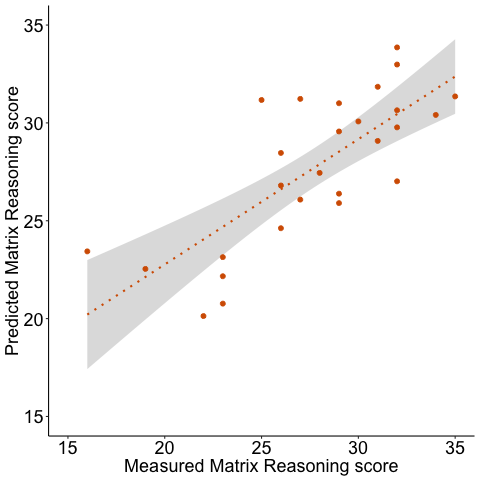

In [138]:
%%R
## scatter plot ##
scatter = ggplot(model_1b, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
xlim(15,35) + 
ylim(15,35)+
xlab("Measured Matrix Reasoning score") +
ylab("Predicted Matrix Reasoning score")

supplementary figure 5a: correlation between actual and predicted matrix reasoning scores for model 1a

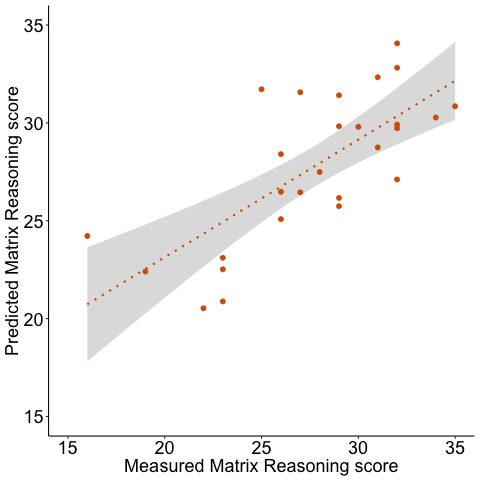

In [139]:
%%R
## scatter plot ##
scatter = ggplot(model_1a, aes(Measured, Predicted)) 
scatter_plot(scatter, "#D55E00") + 
xlim(15,35) + 
ylim(15,35)+
xlab("Measured Matrix Reasoning score") +
ylab("Predicted Matrix Reasoning score")

#### Model comparison
Compare the fit of our best models (model 1a, model 1b) to the alternative nested models (model 2, model 3)

In [147]:
%%R
## load model predictions for alternative models in R ##
model_2 = read.csv('plots/model_2.csv')
model_3 = read.csv('plots/model_3.csv')

Construct a density plot of measured matrix reasoning scores

In [142]:
%%R
## create density plots ##
 density_plot <- function(ggplot_object, color_)
     plot = ggplot_object + 
    
    # density plot
    geom_density(fill=color_) +

    # set axis labels
    xlab("Matrix Reasoning score") +
    ylab("Density\n")   + 
    
    #set axis scale
    scale_x_continuous(limits = c(10,40)) +
    scale_y_continuous(limits = c(0,0.1))+

    # customize theme
     theme_bw() %+replace% 
     theme(
            # set axis titles
            axis.title.x = element_text(color="#333333", size=28), 
            axis.title.y = element_text(color="#333333", angle = 90, 
                                        size=34), 
            # set axis text
            axis.text.x = element_text(color="#333333", size=24),
            axis.text.y = element_text(color="#333333", size=28),
         
            # set legend
            legend.title = element_blank(), 
         
            # set pannel
            panel.grid.major= element_blank(), panel.grid.minor=element_blank(),
            
         )

Set up an overlay in order to layer predicted scores on top of measured matrix reasoning scores. 

In [143]:
%%R
## add overlay of predicted scores to density plot ##
overlay <- function(model, fill){
    plt = geom_density(
                    # data to overlay
                    aes(x = model$Predicted),
        
                   # set transparency
                       alpha = 0.5, 
        
                    # set overlay color
                    fill = fill,
                    color = fill, 
                        )
    return(plt)
}


figure 3c

In [144]:
%%R
## measured scores ##
g0 = ggplot(model_1b, aes(x = Measured))
d0 = density_plot(g0, "light gray")

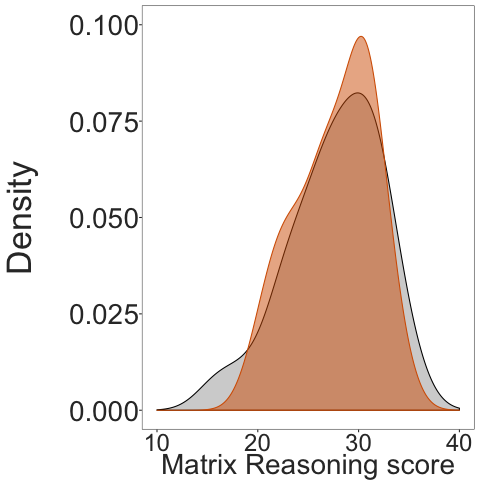

In [145]:
%%R
## overlay model 1b
d1b = d0 + overlay(model_1b,"#D55E00")
d1b

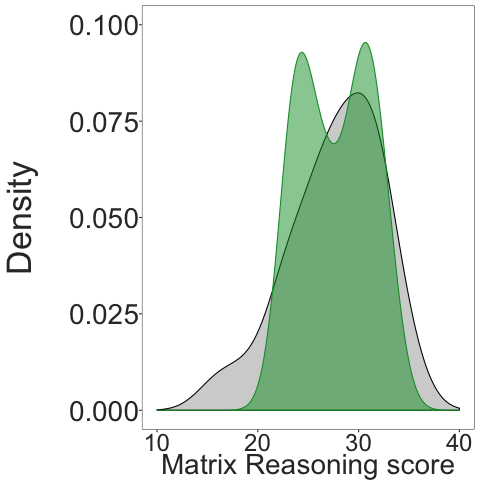

In [148]:
%%R
## overlay model 2
d2 = d0 + overlay(model_2,'#00992F')
d2

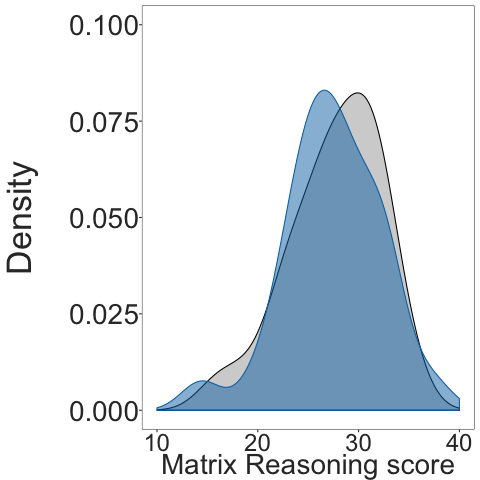

In [149]:
%%R
## overlay model 3
d3 = d0 + overlay(model_3,"#0072B2")
d3

#### bootsrapped MSE
figure 3d: plot the bootstrapped MSE for each model

In [151]:
from matplotlib import pyplot as plt

model 3 has a very large MSE. We will only show the range 0-100 in order to allow visualization of all three models on the same axis. 

In [153]:
bins = np.linspace(1, 100, 200)

NameError: name 'mod_3_boot' is not defined

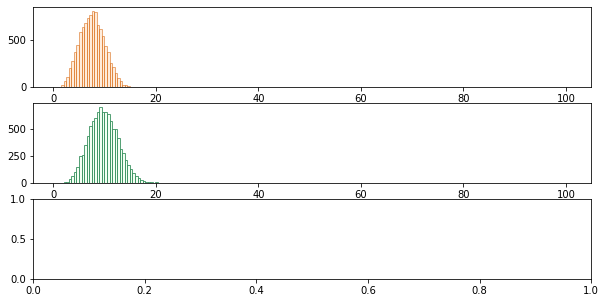

In [154]:
## plot bootrapped MSE ##

fig, axs = plt.subplots(3, figsize=(10, 5))

# histogram for model 1b, 2, 3
axs[0].hist(mod_1b_boot, bins,alpha = 0.5, color = 'peachpuff',edgecolor = "#D55E00")
axs[1].hist(mod_2_boot,bins, alpha = 0.8, color = 'honeydew', edgecolor = 'seagreen')
axs[2].hist(mod_3_boot,bins, alpha = 0.8, color = 'aliceblue', edgecolor = 'royalblue')

# customize plot
for ax in axs.flat:
    # set y-axis limit
    ax.set(ylim=(0, 1000))

    # set tick marks
    ax.set_yticks((0,500,1000))
    ax.set_xticks((0,10,20,30,40,50,60,70,80,90,100))
    
    # bounding box
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# draw vertical line at median MSE
axs[0].axvline(np.median(med_1b), 0,  120, color = 'red')
axs[1].axvline(np.median(med_2), 0,  120, color = 'red')
axs[2].axvline(np.median(med_3), 0,  120, color = 'red')


fig.show()


### Additional Behavior analyses
We can further evaluate our model by look at other common morphological and behavioral metrics. 
* Does sulcal depth predict processing speed? 
* Does cortical thickness predict Matrix Reasoning?

we can compare the predictions from these models to our sulcal depth - matrix reasoning model. 
For non-nested mdoel comparison we will use AIC

In [156]:
## AIC ##

def calculate_aic(n, mse, num_params):
    '''
    input:
    - n = num observations
    - mse =. mean squared error from regression
    - num_params = number of predictors in the model (including the intercept if applicable!)
    '''
    aic = n *np.log(mse) + 2 * num_params
    return aic

AIC is a relative measure. In order to assess the fit we will compare the AIC value of each alternative model to our best model. THe model with the lowest AIC is better. To report a difference the difference in AIC must be > 2. A difference > 10 is considered substantial. 

First we calculate AIC from our best model. We will use this to assess the cortical thickness and processing speed model

In [157]:
## AIC from our tertiary sulcal model 1b ##
AIC_1b = calculate_aic(27, mod_1b[1], 4)

#### Processing speed
First we use the predictors from our best performing model (1b) to predict processing speed

In [158]:
# x-vals are sulcal depth from discovery sample + age
Xr =[ 'AssessmentAge','pmfs_i' ,  'pimfs' ]

# Predictor is CrossOut score
yr = 'CrossoutRawScore'

In [166]:
## predict Crossout score from depth ##
model_crOut = lm_loocv(Replication_RH_depth[Xr], Replication_RH_depth[yr], "model_crOut")

In [165]:
model_crOut[0], model_crOut[1]

(0.4554024337877026, 20.534839369058478)

In [160]:
AIC_crOut = calculate_aic(27, model_crOut[1], 4)

In [161]:
change_AIC = AIC_crOut - AIC_1b

#### cortical thickness
We replace depth values for each of the sulci in our best performing model (1b) with cortical thickness, and then predict reasoning score

In [168]:
## load cortical thickness data ## 
Replication_thickness = pd.read_csv('Replication_thick.csv')

In [169]:
## select RH sulci ## 
Replication_RH_thickness = Replication_thickness[Replication_thickness['hemi']=="rh"]

In [170]:
# y predictor is now Matrix R
yr = 'MatrixR'

In [171]:
## predict matrix reasoning score from thickness ## 
model_thick = lm_loocv(Replication_RH_thickness[Xr], Replication_RH_thickness[yr], "model_thick")

In [172]:
print(model_thick[0], model_thick[1])

0.3322582346623024 13.54352502370809


In [ ]:
AIC_thick = calculate_aic(27, model_thick[1], 4)

In [ ]:
change_AIC = AIC_thick - AIC_1b

#### plot 
Visualize the fit of these models and use the AIC metric to compare them to model 1b

In [174]:
%%R
## load model output as R dataframe ## 
model_thickness = read.csv('plots/model_thick.csv')
model_crOut = read.csv('plots/model_crOut.csv')


Error in file(file, "rt") : cannot open the connection


/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in file(file, "rt") : cannot open the connection

  warnings.warn(x, RRuntimeWarning)
/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In file(file, "rt") :
  warnings.warn(x, RRuntimeWarning)
/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  cannot open file 'model/model_thick.csv': No such file or directory

  warnings.warn(x, RRunti

Supplementary figure 6a: Scatter plot of predicted vs. actual score using cortical thickness

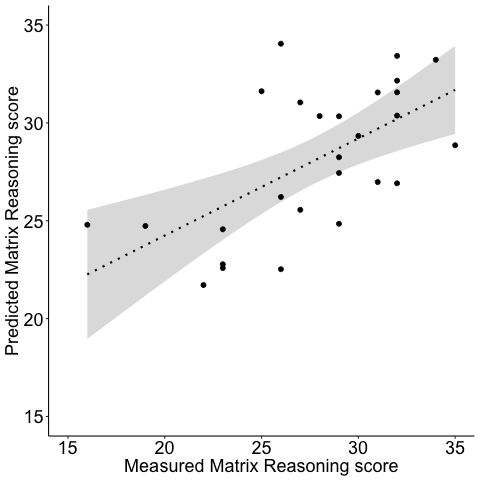

In [175]:
%%R
## scatter plot of measured vs. predicted ##
scatter = ggplot(model_thickness, aes(Measured, Predicted)) 
scatter_plot(scatter, "black") + 
xlim(15,35) + 
ylim(15,35)+
xlab("Measured Matrix Reasoning score") +
ylab("Predicted Matrix Reasoning score")

We can then compare the MSE from this model to the same model using sulcal depth. These are non-nested so we will use the AIC value to compare

In [182]:
%%R
## organize data for bar plot 
model = c("Depth", "Thickness", )

# MSE from both models
MSE = c( 8.52, 13.54)

data_thick = data.frame(model, MSE)


Error in c("Depth", "Thickness", ) : argument 3 is empty


/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in c("Depth", "Thickness", ) : argument 3 is empty

  warnings.warn(x, RRuntimeWarning)


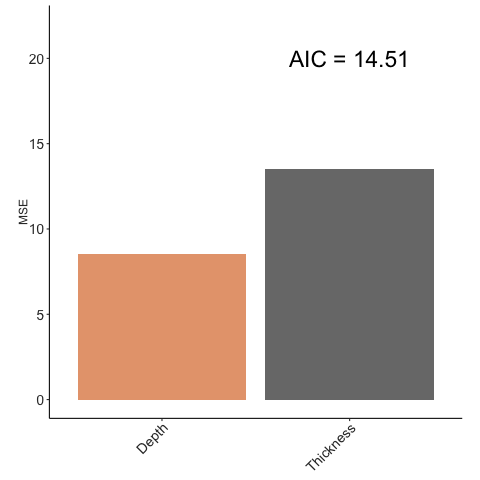

In [184]:
%%R
## barplot depth vs thickness MSE ##
    plot = ggplot(data_thick, aes(model, MSE)) +
        
    # barplot 
    geom_col(alpha = 0.6, fill = c('#D55E00',"black" )) +
    
    # set limits
    ylim (0, 22)+

  # add AIC val
    annotate("text", label = "AIC = 14.51", 
             # adjust text position
             x=2, y=20, 
            # adjust text size
             size = 8) +
             
    # set theme
    set_theme()
plot

We see that our original model has a lower MSE than the cortical thickness model. The change in AIC is > 10 so this is considered a large difference.

supplementary figure 6b: scatter plot of predicted vs. actual cross out scores.

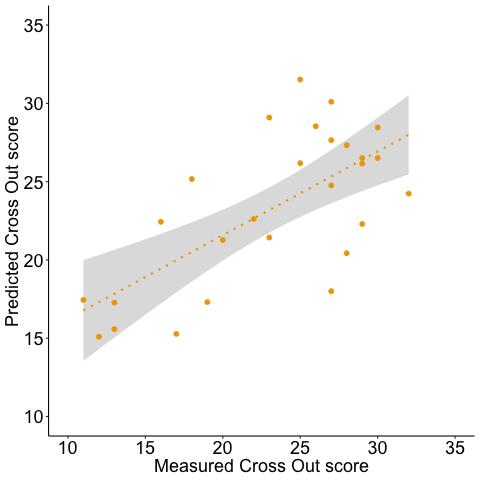

In [185]:
%%R
## scatter plot of measured vs. predicted ##
scatter = ggplot(model_crOut, aes(Measured, Predicted)) 
scatter_plot(scatter, "#efa500") + 
xlim(10,35) + 
ylim(10,35)+
xlab("Measured Cross Out score") +
ylab("Predicted Cross Out score")

We can compare this to the performance of the same model when we use it to predict matrix reasoning. These are non-nested models so we will use AIC.

In [188]:
%%R
## organize data for bar plot 
model = c("Cross-Out", "Matrix Reasoning")

# MSE from both models
MSE = c(20.53, 8.52)

data_CR = data.frame(model, MSE)

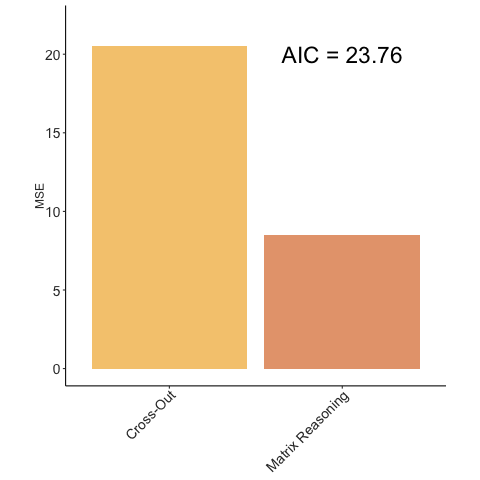

In [191]:
%%R
## barplot depth vs thickness MSE ##
    plot = ggplot(data_CR, aes(model, MSE)) +
        
    # barplot 
    geom_col(alpha = 0.6, fill = c("#efa500", '#D55E00')) +
    
    # set limits
    ylim (0, 22)+

    # add AIC val
    annotate("text", label = "AIC = 23.76", 
             # adjust text position
             x=2, y=20, 
            # adjust text size
             size = 8
            ) + 

    # set theme
    set_theme()
plot

This model does a substantially better job predicting matrix reasoning than cross-out score

## Suppementary materials

Additional analyses that are used to generate supplementary figure 3

## Age
Characterize the age both samples 

In [194]:
%%R
## load depth and behavior data in R ## 
Discovery_depth = read.csv("Discovery_depth.csv")
Replication_depth = read.csv("Replication_depth.csv")

Get the mean age for each sample

In [196]:
%%R
# Discovery 
Discovery_age = mean(Discovery_depth$AssessmentAge)

# Replication
Replication_age = mean(Replication_depth$AssessmentAge)

Calculate a test statistic to test for differences in age between samples

In [197]:
%%R
## confirm age is compatible between samples
# corr for unequal var is default
t.test(Discovery_depth$AssessmentAge, Replication_depth$AssessmentAge)


	Welch Two Sample t-test

data:  Discovery_depth$AssessmentAge and Replication_depth$AssessmentAge
t = -0.076968, df = 107.51, p-value = 0.9388
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.439640  1.332021
sample estimates:
mean of x mean of y 
 12.41286  12.46667 



No significant differences in age between groups

#### Correlate age with reasoning score

In [198]:
%%R
## Correlate age and Matrix Reasoning in both samples ##
Discovery_age_corr = cor.test(Discovery_depth$MatrixR, Discovery_depth$AssessmentAge)
Discovery_age_corr


	Pearson's product-moment correlation

data:  Discovery_depth$MatrixR and Discovery_depth$AssessmentAge
t = 5.4179, df = 54, p-value = 1.435e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3916239 0.7407595
sample estimates:
      cor 
0.5934264 



In [199]:
%%R
## Correlate age and Matrix Reasoning in both samples ##
Replication_age_corr = cor.test(Replication_depth$MatrixR, Replication_depth$AssessmentAge)
Replication_age_corr


	Pearson's product-moment correlation

data:  Replication_depth$MatrixR and Replication_depth$AssessmentAge
t = 8.0003, df = 52, p-value = 1.272e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5929718 0.8429087
sample estimates:
      cor 
0.7427954 



Age is correlated with Reasoning. This necessitates the inclusion of age in our model evaluation

#### Correlate age with sulcal morphology. 
Only to visualize correlation coefficients. We do not report significant values as there are multiple comparisons which will inflate our p-value

In [200]:
%%R
## separate into lh and rh
Discovery_depth_rh = Discovery_depth[Discovery_depth$hemi == 'rh',]
Discovery_depth_lh = Discovery_depth[Discovery_depth$hemi == 'lh',]

In [201]:
%%R
Replication_depth_rh = Replication_depth[Replication_depth$hemi == 'rh',]
Replication_depth_lh = Replication_depth[Replication_depth$hemi == 'lh',]

Construct a bar plot of correlation coefficients (supplementary figure 3a)

In [202]:
%%R
## construct a correlation matrix with cols of interest ## 
corr_cols <- function(df, y, x){
# ---------------
# input = dataframe, value of interest, cols to corr with val of interest.
# Return correlation coefficients #
# --------------
    # corr y with each col in X
    corr = cor(df[y], df[x])
    # save coefs as a dataframe
    corr.df = data.frame(corr)

    return (corr.df)
}

In [203]:
%%R
## Discovery - Corr between age and depth of each sulcus

discovery_rh_corr = corr_cols(Discovery_depth_rh, 'AssessmentAge', c(6:17))
discovery_lh_corr =  corr_cols(Discovery_depth_lh, 'AssessmentAge', c(6:17))

In [204]:
%%R
## Replication - Corr between age and depth of each sulcus

replication_rh_corr = corr_cols(Replication_depth_rh, 'AssessmentAge', c(6:17))
replication_lh_corr =  corr_cols(Replication_depth_lh, 'AssessmentAge', c(6:17))

#### Visualize tertiary sulci and age 
Specifically we are interested in whether the variability in tertiay sulcal depth is related to age. Lets plot the relationship between sulcal depth and age for all of our tertiary sulci (Supplementary figure 3b-c)

Load in tertiary sulcal depth (in both hemispheres) and age values as an R dataframe for plotting

In [ ]:
%%R
## tertiary sulci only ## 
Discovery_tert_age = read.csv('plots/Discovery_tertiary_age')
Replication_tert_age = read.csv('plots/Replication_tertiary_age')


Set up a scatter plot to visualize the relationship between age and tertiary sulcal depth

In [206]:
%%R
### Create scatter plots ###
scatter_age <- function( data){
    
    # order of labels 
    data$label = factor(data$label,
                           levels=c("pmfs_p","pmfs_i","pmfs_a", 'pimfs'))
                           
    ##  separate data into lh and rh ##
    data_rh = subset(data, hemi == "rh")
    data_lh = subset(data, hemi == "lh")
    
    ## plot ## 
    plot = ggplot(data_rh, aes(AssessmentAge, norm_mean_sulcal_depth)) + 
    
    # rh scatter
    geom_point( size = 1, color = "#D55E00") +
    #rh trend line
    geom_smooth( method = 'lm',
                se = FALSE,  color = "#D55E00") + 
    
    #lh scatter
    geom_point(data = data_lh, shape = 17, size = 1, color = "#fdae6b") + 
    # lh trend line
    geom_smooth(data =data_lh ,method = 'lm', se = FALSE,  color = "#fdae6b")+
    
    # set y-axis 
    ylab ('Normalized Mean Sulcal Depth') + 
 
    
    # set x-axis limits 
     scale_x_continuous(name="Age (years)", 
                        breaks=c(6, 8, 10, 12,14,16,18)) +
    
    # facet wrap by label
    facet_wrap(~label, nrow = 1)
    
    
return (plot)
}
# Discovery (facet wrap)
# Replication (face wrap)

In [207]:
%%R
## plot discovery ## 
plt = scatter_age(Discovery_tert_age) + set_theme()
plt


Error in factor(data$label, levels = c("pmfs_p", "pmfs_i", "pmfs_a", "pimfs")) : 
  object 'Discovery_tert_age' not found


/Users/willav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in factor(data$label, levels = c("pmfs_p", "pmfs_i", "pmfs_a", "pimfs")) : 
  object 'Discovery_tert_age' not found

  warnings.warn(x, RRuntimeWarning)


In [ ]:
%%R 
## plot replications ## 
plt = scatter_age(Replication_tert_age) + set_theme()
plt